TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      (None, 100, 4)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          102144    
_________________________________________________________________
e_2 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          295680    
_________________________________________________________________
e_4 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
dense_1 (Dense)              (None, 100, 2)            514       
____________________________________________

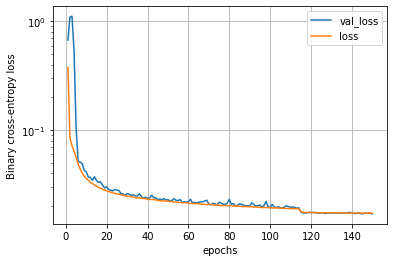

SNR: 1 bit error rate =  0.2109809
SNR: 2 bit error rate =  0.1900722
SNR: 3 bit error rate =  0.1681313
SNR: 4 bit error rate =  0.1452016
SNR: 5 bit error rate =  0.1204233
SNR: 6 bit error rate =  0.0951839
SNR: 7 bit error rate =  0.0701813
SNR: 8 bit error rate =  0.0468589
SNR: 9 bit error rate =  0.0276674
SNR: 10 bit error rate =  0.0141955
SNR: 11 bit error rate =  0.0061359
SNR: 12 bit error rate =  0.0022032
SNR: 13 bit error rate =  0.0006708
SNR: 14 bit error rate =  0.0001631
SNR: 15 bit error rate =  4.13e-05
SNR: 16 bit error rate =  9.8e-06
SNR: 17 bit error rate =  2.4e-06
SNR: 18 bit error rate =  5e-07
SNR: 19 bit error rate =  3e-07


In [ ]:
% tensorflow_version 1.x

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, Input, Conv1D, TimeDistributed, Flatten, Activation, ZeroPadding1D
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as KR
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import GRU, LSTM, Bidirectional, Reshape
import tensorflow as tf

'''
 --- COMMUNICATION PARAMETERS ---
'''

# Bits per Symbol
k = 4
power = 0.3482**2 + 0.8704**2 + 0.3482**2

# Number of symbols
L = 100

# Channel Use
n = 1

# Effective Throughput
#  bits per symbol / channel use
R = k / n

# Eb/N0 used for training
train_Eb_dB = 11

# Noise Standard Deviation
noise_sigma = np.sqrt(power / (2 * R * 10 ** (train_Eb_dB / 10)))


# Number of messages used for training, each size = k*L
batch_size = 1000

train_num = batch_size*150



early_stopping_patience = 100

epochs = 150

optimizer = Adam(lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'model_LBC_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)


train_label = np.random.randint(0,2, size = (train_num,k*L))
train_data = np.reshape(train_label, newshape=(train_num, L, k))  # input


# Define Power Norm for Tx
def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2 * mean)  # 2 = I and Q channels


# Define Channel Layers including AWGN and Flat Rayleigh fading
#  x: input data
#  sigma: noise std
def channel_layer(x, sigma):

    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)

    return x + w

def ISI_layer(x):
    taps = 3
    h = np.array([0.3482, 0.8704, 0.3482]) # weights
    dim = x.shape[1] 
    split = Lambda(lambda x:tf.split(x,num_or_size_splits=2,axis=2))(x)
    ISI_1_0 = split[0]
    ISI_2_0 = split[1]

    # print(ISI_1_0.shape)
    ISI_1_1 = ZeroPadding1D(1)(ISI_1_0)
    ISI_1_1 = Lambda(lambda x: x[:,0:L])(ISI_1_1)
    ISI_1_2 = ZeroPadding1D(1)(ISI_1_1)
    ISI_1_2 = Lambda(lambda x: x[:,0:L])(ISI_1_2)

    ISI_2_1 = ZeroPadding1D(1)(ISI_2_0)
    ISI_2_1 = Lambda(lambda x: x[:,0:L])(ISI_2_1)
    ISI_2_2 = ZeroPadding1D(1)(ISI_2_1)
    ISI_2_2 = Lambda(lambda x: x[:,0:L])(ISI_2_2)

    ISI1 = h[0]*ISI_1_0+h[1]*ISI_1_1+h[2]*ISI_1_2
    ISI2 = h[0]*ISI_2_0+h[1]*ISI_2_1+h[2]*ISI_2_2

    ISI_x =  KR.concatenate((ISI1, ISI2), axis=-1)   
    # print(ISI_x.shape) 
    return ISI_x    

model_input = Input(batch_shape=(None, L, k), name='input_bits')

e = Bidirectional(GRU(name='e_1', units=128, activation='tanh', return_sequences=True))(model_input)
e = BatchNormalization(name='e_2')(e)
e = Bidirectional(GRU(name='e_3', units=128, activation='tanh', return_sequences=True))(e)
e = BatchNormalization(name='e_4')(e)


#e = Conv1D(filters=2*n, strides=1, kernel_size=3, activation='linear',padding='same')(e)
#e = TimeDistributed(Dense(2*n, activation = "linear"))(e)
e = Dense(2*n, activation = "linear")(e)

e = Lambda(normalization, name='power_norm')(e)

#ISI#
e = Lambda(ISI_layer, name='ISI')(e)

y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e)


d = Bidirectional(GRU(name='bi_1', units=128, activation='tanh', return_sequences=True))(y_h)
d = BatchNormalization(name='bi_2')(d)
d = Bidirectional(GRU(name='bi_3', units=128, activation='tanh', return_sequences=True))(d)
d = BatchNormalization(name='bi_4')(d)


#model_output = Conv1D(filters=k, strides=1, kernel_size=3, activation='sigmoid',padding='same')(d)
#model_output = TimeDistributed(Dense(k, activation = "sigmoid"))(d)
model_output = Dense(k, activation = "sigmoid")(d)

sys_model = Model(model_input, model_output)
encoder = Model(model_input, e)
sys_model.summary()
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

decode_input = Input(batch_shape=(None, L, 2*n))
dec = sys_model.layers[-5](decode_input)
dec = sys_model.layers[-4](dec)
dec = sys_model.layers[-3](dec)
dec = sys_model.layers[-2](dec)
dec = sys_model.layers[-1](dec)
decoder = Model(decode_input, dec)
decoder.summary()
print('starting train the NN...')
start = time.clock()

# TRAINING
mod_history = sys_model.fit(train_data, train_data,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1, callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')


# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
#acc = hist_dict['acc']
# val_acc = hist_dict['val_acc']
print('loss:',loss)
print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true') 
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()

sys_model.save('/content/drive/My Drive/rnn_AE11_model.h5')
encoder.save('/content/drive/My Drive/rnn_AE11_enc.h5')

##
def AWGN(x, SNR):  
  EbNo=10.0**(SNR/10.0)
  noise_std = np.sqrt(power/(2*R*EbNo))
  n = np.random.normal(0,noise_std,np.shape(x))
  noisy_signal = n + x
  return noisy_signal

test_num = 25000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input 

NN = np.shape(test_label)[0]* np.shape(test_label)[1]

err = []
EbNo_dB = []

for SNR in range(1, 21, 1):
  
  test_encoded = encoder.predict(test_data)

  # AWGN
  test_noisy = AWGN(test_encoded, SNR)

  # decoder 
  predict = decoder.predict(test_noisy)
 
  # binary form 
  '''
  binary_predict = []

  for item in predict: 
    binary_predict.append([1 if i>=0.5 else 0 for i in item])
  '''
  predict[(predict >= 0.5)] = 1
  predict[(predict < 0.5)] = 0

  num_error = (test_data != predict).astype(int).sum()

  error_rate = num_error/NN
  err.append(error_rate)
  EbNo_dB.append(SNR)
  print('SNR:', SNR, 'bit error rate = ', error_rate)


print(err)
import matplotlib.pyplot as plt
plt.plot(EbNo_dB, err, 'b')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Block Error Rate')
plt.grid()  



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#% tensorflow_version 1.x

% tensorflow_version 1.x

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, Input, Conv1D, TimeDistributed, Flatten, Activation, ZeroPadding1D
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as KR
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import GRU, LSTM, Bidirectional, Reshape
import tensorflow as tf

'''
 --- COMMUNICATION PARAMETERS ---
'''

# Bits per Symbol
k = 4
power = 0.3482**2 + 0.8704**2 + 0.3482**2

# Number of symbols
L = 100

# Channel Use
n = 1

# Effective Throughput
#  bits per symbol / channel use
R = k / n

# Eb/N0 used for training
train_Eb_dB = 11

# Noise Standard Deviation
noise_sigma = np.sqrt(power / (2 * R * 10 ** (train_Eb_dB / 10)))


# Number of messages used for training, each size = k*L
batch_size = 1000

train_num = batch_size*150



early_stopping_patience = 100

epochs = 150

optimizer = Adam(lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'model_LBC_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)


train_label = np.random.randint(0,2, size = (train_num,k*L))
train_data = np.reshape(train_label, newshape=(train_num, L, k))  # input


# Define Power Norm for Tx
def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2 * mean)  # 2 = I and Q channels


# Define Channel Layers including AWGN and Flat Rayleigh fading
#  x: input data
#  sigma: noise std
def channel_layer(x, sigma):

    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)

    return x + w

def ISI_layer(x):
    taps = 3
    h = np.array([0.3482, 0.8704, 0.3482]) # weights
    dim = x.shape[1] 
    split = Lambda(lambda x:tf.split(x,num_or_size_splits=2,axis=2))(x)
    ISI_1_0 = split[0]
    ISI_2_0 = split[1]

    # print(ISI_1_0.shape)
    ISI_1_1 = ZeroPadding1D(1)(ISI_1_0)
    ISI_1_1 = Lambda(lambda x: x[:,0:L])(ISI_1_1)
    ISI_1_2 = ZeroPadding1D(1)(ISI_1_1)
    ISI_1_2 = Lambda(lambda x: x[:,0:L])(ISI_1_2)

    ISI_2_1 = ZeroPadding1D(1)(ISI_2_0)
    ISI_2_1 = Lambda(lambda x: x[:,0:L])(ISI_2_1)
    ISI_2_2 = ZeroPadding1D(1)(ISI_2_1)
    ISI_2_2 = Lambda(lambda x: x[:,0:L])(ISI_2_2)

    ISI1 = h[0]*ISI_1_0+h[1]*ISI_1_1+h[2]*ISI_1_2
    ISI2 = h[0]*ISI_2_0+h[1]*ISI_2_1+h[2]*ISI_2_2

    ISI_x =  KR.concatenate((ISI1, ISI2), axis=-1)   
    # print(ISI_x.shape) 
    return ISI_x    

model_input = Input(batch_shape=(None, L, k), name='input_bits')

e = Bidirectional(GRU(name='e_1', units=128, activation='tanh', return_sequences=True))(model_input)
e = BatchNormalization(name='e_2')(e)
e = Bidirectional(GRU(name='e_3', units=128, activation='tanh', return_sequences=True))(e)
e = BatchNormalization(name='e_4')(e)


#e = Conv1D(filters=2*n, strides=1, kernel_size=3, activation='linear',padding='same')(e)
#e = TimeDistributed(Dense(2*n, activation = "linear"))(e)
e = Dense(2*n, activation = "linear")(e)

e = Lambda(normalization, name='power_norm')(e)

#ISI#
e = Lambda(ISI_layer, name='ISI')(e)

y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e)


d = Bidirectional(GRU(name='bi_1', units=128, activation='tanh', return_sequences=True))(y_h)
d = BatchNormalization(name='bi_2')(d)
d = Bidirectional(GRU(name='bi_3', units=128, activation='tanh', return_sequences=True))(d)
d = BatchNormalization(name='bi_4')(d)


#model_output = Conv1D(filters=k, strides=1, kernel_size=3, activation='sigmoid',padding='same')(d)
#model_output = TimeDistributed(Dense(k, activation = "sigmoid"))(d)
model_output = Dense(k, activation = "sigmoid")(d)

sys_model = Model(model_input, model_output)
encoder = Model(model_input, e)
sys_model.summary()
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

decode_input = Input(batch_shape=(None, L, 2*n))
dec = sys_model.layers[-5](decode_input)
dec = sys_model.layers[-4](dec)
dec = sys_model.layers[-3](dec)
dec = sys_model.layers[-2](dec)
dec = sys_model.layers[-1](dec)
decoder = Model(decode_input, dec)  

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      (None, 100, 4)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          102144    
_________________________________________________________________
e_2 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          295680    
_________________________________________________________________
e_4 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
dense_1 (Dense)              (None, 100, 2)            514       
________________________________________________

In [ ]:
sys_model=load_model('/content/drive/My Drive/rnn_AE11_model.h5', custom_objects={"tf": tf,"KR": KR,"ZeroPadding1D": ZeroPadding1D,"L":100})
encoder=load_model('/content/drive/My Drive/rnn_AE11_enc.h5', custom_objects={"tf": tf,"KR": KR,"ZeroPadding1D": ZeroPadding1D,"L":100})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

decode_input = Input(batch_shape=(None, L, 2*n))
dec = sys_model.layers[-5](decode_input)
dec = sys_model.layers[-4](dec)
dec = sys_model.layers[-3](dec)
dec = sys_model.layers[-2](dec)
dec = sys_model.layers[-1](dec)
decoder = Model(decode_input, dec)
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 2)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 256)          100608    
_________________________________________________________________
bi_2 (BatchNormalization)    (None, 100, 256)          1024      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 256)          295680    
_________________________________________________________________
bi_4 (BatchNormalization)    (None, 100, 256)          1024      
_________________________________________________________________
dense_2 (Dense)              (None, 100, 4)            1028      
Total params: 399,364
Trainable params: 398,340
Non-trainable params: 1,024
_________________________________________________

SNR: 1 bit error rate =  0.2108497
SNR: 2 bit error rate =  0.1897287
SNR: 3 bit error rate =  0.16788
SNR: 4 bit error rate =  0.1448597
SNR: 5 bit error rate =  0.1204219
SNR: 6 bit error rate =  0.0953831
SNR: 7 bit error rate =  0.0701442
SNR: 8 bit error rate =  0.0469103
SNR: 9 bit error rate =  0.0279116
SNR: 10 bit error rate =  0.0141773
SNR: 11 bit error rate =  0.0062415
SNR: 12 bit error rate =  0.0022025
SNR: 13 bit error rate =  0.0006546
SNR: 14 bit error rate =  0.0001711
SNR: 15 bit error rate =  3.68e-05
SNR: 16 bit error rate =  8.9e-06
SNR: 17 bit error rate =  2.7e-06
SNR: 18 bit error rate =  1.4e-06
SNR: 19 bit error rate =  4e-07
SNR: 20 bit error rate =  1e-07
[0.2108497, 0.1897287, 0.16788, 0.1448597, 0.1204219, 0.0953831, 0.0701442, 0.0469103, 0.0279116, 0.0141773, 0.0062415, 0.0022025, 0.0006546, 0.0001711, 3.68e-05, 8.9e-06, 2.7e-06, 1.4e-06, 4e-07, 1e-07]


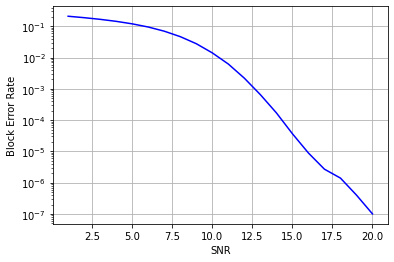

In [ ]:
##
def AWGN(x, SNR):  
  EbNo=10.0**(SNR/10.0)
  noise_std = np.sqrt(power/(2*R*EbNo))
  n = np.random.normal(0,noise_std,np.shape(x))
  noisy_signal = n + x
  return noisy_signal

test_num = 25000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input 

NN = np.shape(test_label)[0]* np.shape(test_label)[1]

err = []
EbNo_dB = []

for SNR in range(1, 21, 1):
  
  test_encoded = encoder.predict(test_data)

  # AWGN
  test_noisy = AWGN(test_encoded, SNR)

  # decoder 
  predict = decoder.predict(test_noisy)
 
  # binary form 
  '''
  binary_predict = []

  for item in predict: 
    binary_predict.append([1 if i>=0.5 else 0 for i in item])
  '''
  predict[(predict >= 0.5)] = 1
  predict[(predict < 0.5)] = 0

  num_error = (test_data != predict).astype(int).sum()

  error_rate = num_error/NN
  err.append(error_rate)
  EbNo_dB.append(SNR)
  print('SNR:', SNR, 'bit error rate = ', error_rate)


print(err)
import matplotlib.pyplot as plt
plt.plot(EbNo_dB, err, 'b')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Block Error Rate')
plt.grid()  


SNR: 17 bit error rate =  2.6e-06
SNR: 18 bit error rate =  3e-07
SNR: 19 bit error rate =  2e-07
SNR: 20 bit error rate =  0.0
SNR: 21 bit error rate =  0.0
SNR: 22 bit error rate =  0.0
SNR: 23 bit error rate =  0.0
[2.6e-06, 3e-07, 2e-07, 0.0, 0.0, 0.0, 0.0]


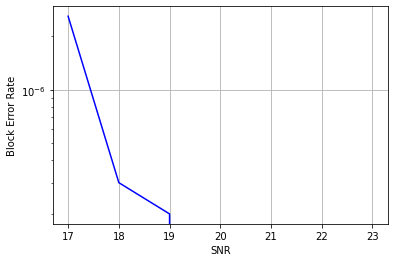

In [ ]:
##
def AWGN(x, SNR):  
  EbNo=10.0**(SNR/10.0)
  noise_std = np.sqrt(power/(2*R*EbNo))
  n = np.random.normal(0,noise_std,np.shape(x))
  noisy_signal = n + x
  return noisy_signal

test_num = 25000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input 

NN = np.shape(test_label)[0]* np.shape(test_label)[1]

err = []
EbNo_dB = []

for SNR in range(17, 24, 1):
  
  test_encoded = encoder.predict(test_data)

  # AWGN
  test_noisy = AWGN(test_encoded, SNR)

  # decoder 
  predict = decoder.predict(test_noisy)
 
  # binary form 
  '''
  binary_predict = []

  for item in predict: 
    binary_predict.append([1 if i>=0.5 else 0 for i in item])
  '''
  predict[(predict >= 0.5)] = 1
  predict[(predict < 0.5)] = 0

  num_error = (test_data != predict).astype(int).sum()

  error_rate = num_error/NN
  err.append(error_rate)
  EbNo_dB.append(SNR)
  print('SNR:', SNR, 'bit error rate = ', error_rate)


print(err)
import matplotlib.pyplot as plt
plt.plot(EbNo_dB, err, 'b')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Block Error Rate')
plt.grid()  